In [1]:
import numpy as np
import pandas as pd

dn = '/Users/aa/lab/kaggle/couponpurchase/data/'

In [2]:
import csv

def read_csv_purchases(fn):
    ret = []
    with open(fn, 'r') as f:
        a = csv.reader(f)
        next(a)
        for row in a:
            ret.append(row[1].split(' ') if row[1] else [])
    return ret

In [22]:
actual = read_csv_purchases('actual-010.csv')
predicted = read_csv_purchases('archive/output-012b.csv')

#### Users with min 1 correct prediction

In [39]:
sum([1 for a,b in zip(actual, predicted) if len(set(a).intersection(set(b))) > 0])

650

In [62]:
usrid_nopred = [i for i,(a,b) in enumerate(zip(actual, predicted)) if len(set(a).intersection(set(b))) == 0 and len(a) > 0]
usrid_okpred = [i for i,(a,b) in enumerate(zip(actual, predicted)) if len(set(a).intersection(set(b))) > 0 and len(a) > 0]

#### Data setup

In [100]:
users = pd.read_csv(dn+'common/user_list.csv', parse_dates=['REG_DATE', 'WITHDRAW_DATE'])
usr_nopred = users.iloc[usrid_nopred]
usr_okpred = users.iloc[usrid_okpred]
prch = pd.read_csv(dn+'train/coupon_detail_train.csv', parse_dates=['I_DATE'])

#### How many items did nopred users purchase -vs- okpred users

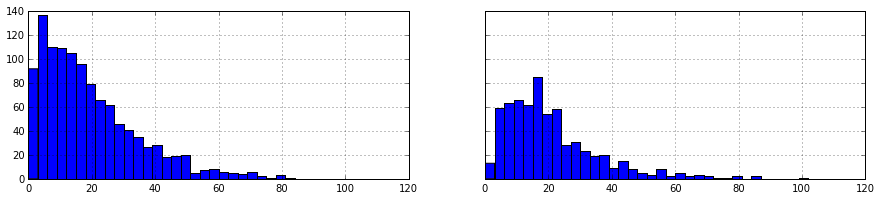

In [102]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
fig.set_size_inches(15,3)
prch[prch.USER_ID_hash.isin(usr_nopred.USER_ID_hash)].groupby('USER_ID_hash').COUPON_ID_hash.count().hist(ax=ax[0], 
                                                                                                          bins=np.arange(0,120,3))
prch[prch.USER_ID_hash.isin(usr_okpred.USER_ID_hash)].groupby('USER_ID_hash').COUPON_ID_hash.count().hist(ax=ax[1], 
                                                                                                          bins=np.arange(0,120,3))

#### What other differences exist between users in nopred -vs- okpred

In [111]:
print(usr_nopred.SEX_ID.value_counts())
print(usr_okpred.SEX_ID.value_counts())
print('F/M ratio: nopred={:.3f}, okpred={:.3f}'.format(715/423, 383/267))
print(715+383, 423+267)

f    715
m    423
dtype: int64
f    383
m    267
dtype: int64
F/M ratio: nopred=1.690, okpred=1.434
1098 690


In [123]:
df = pd.DataFrame({'a':[0,1,2,3,4,4], 'b':[1,2,2,3,1,3], 'c':[10,10,20,30,40,10]})

In [124]:
df

,a,b,c
0,0,1,10
1,1,2,10
2,2,2,20
3,3,3,30
4,4,1,40
5,4,3,10


In [118]:
df.pivot(index='a', columns='b', values='c').fillna(0)

b,1,2,3
a,,,
0,10,0,0
1,0,10,0
2,0,20,0
3,0,0,30
4,40,0,10


In [130]:
df.pivot_table(index='a', columns='b', aggfunc=[len], fill_value=0)

len      
    c      
b   1  2  3
a          
0   1  0  0
1   0  1  0
2   0  1  0
3   0  0  1
4   1  0  1

In [144]:
from sklearn.feature_extraction import DictVectorizer

def encode_categorical(dftrain, dftest, cols):
    vec = DictVectorizer(separator='_')
    v_dftrain = pd.DataFrame(vec.fit_transform(dftrain[cols].to_dict(orient='records')).toarray())
    v_dftest = pd.DataFrame(vec.transform(dftest[cols].to_dict(orient='records')).toarray())
    
    v_dftrain.columns = vec.get_feature_names()
    v_dftest.columns = vec.get_feature_names()
    
    v_dftrain.index = dftrain.index
    v_dftest.index = dftest.index

    dftrain = dftrain.drop(cols, axis=1)
    dftrain = dftrain.join(v_dftrain)

    dftest = dftest.drop(cols, axis=1)
    dftest = dftest.join(v_dftest)
    
    return dftrain, dftest


df1 = pd.DataFrame(['c1', 'c2', 'c3', 'c4', 'c4'], columns=['a'])
df1['b'] = ['CA', 'NJ', 'NY', 'CA', 'WA']

df2 = pd.DataFrame(['d1', 'd2', 'd3'], columns=['a'])
df2['b'] = ['CA', 'NJ', 'NY']

print(df1)
print(df2)

df1, df2 = encode_categorical(df1, df2, ['b'])


df1.set_index('a', inplace=True)
df2.set_index('a', inplace=True)

print(df1)
print(df2)

df1.groupby(df1.index).sum()

    a   b
0  c1  CA
1  c2  NJ
2  c3  NY
3  c4  CA
4  c4  WA
    a   b
0  d1  CA
1  d2  NJ
2  d3  NY
    b_CA  b_NJ  b_NY  b_WA
a                         
c1     1     0     0     0
c2     0     1     0     0
c3     0     0     1     0
c4     1     0     0     0
c4     0     0     0     1
    b_CA  b_NJ  b_NY  b_WA
a                         
d1     1     0     0     0
d2     0     1     0     0
d3     0     0     1     0


,b_CA,b_NJ,b_NY,b_WA
a,,,,
c1,1,0,0,0
c2,0,1,0,0
c3,0,0,1,0
c4,1,0,0,1


In [146]:
np.log10(30)

1.4771212547196624